<a href="https://colab.research.google.com/github/Elwing-Chou/tibaml1027/blob/main/cifar10_gap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
from tensorflow.keras.datasets.cifar10 import load_data
(x_train, y_train), (x_test, y_test) = load_data()

In [64]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 1)
(10000, 1)


In [65]:
# !!! (50000, 1) =/= (50000, )
y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

In [66]:
trans = [
    "airplane",										
    "automobile",										
    "bird",										
    "cat",										
    "deer",										
    "dog",										
    "frog",										
    "horse",										
    "ship",										
    "truck",
]

automobile


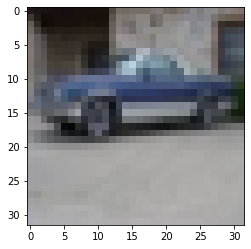

In [67]:
import matplotlib.pyplot as plt
idx = 10000
print(trans[y_train[idx][0]])
plt.imshow(x_train[idx])

In [68]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Flatten, Dropout
layers = [
    # CNN
    # 一個過濾器: 3 * 3 * 3(前一層通道數) * 64(過濾器數目) + 64(bias) = 1792
    Conv2D(64, 3, padding="same", activation="relu", input_shape=(32, 32, 3)),
    MaxPooling2D(),
    # 一個過濾器: 3 * 3 * 64(前一層通道數) * 128(過濾器數目) + 128(bias) = 73856
    Conv2D(128, 3, padding="same", activation="relu"),
    MaxPooling2D(),
    Conv2D(256, 3, padding="same", activation="relu"),
    MaxPooling2D(),
    Conv2D(512, 3, padding="same", activation="relu"),
    GlobalAveragePooling2D(),
    Dense(10, activation="softmax")
]
model = Sequential(layers)
model.summary(line_length=100)

Model: "sequential_8"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 conv2d_32 (Conv2D)                          (None, 32, 32, 64)                      1792           
                                                                                                    
 max_pooling2d_26 (MaxPooling2D)             (None, 16, 16, 64)                      0              
                                                                                                    
 conv2d_33 (Conv2D)                          (None, 16, 16, 128)                     73856          
                                                                                                    
 max_pooling2d_27 (MaxPooling2D)             (None, 8, 8, 128)                       0              
                                                                     

In [69]:
# 一個輸出(二元分類): BinaryCrossEntropy p log 1/q + (1 - p) log 1/1-q
# 多個輸出(多元分類): CategoricalCrossEntropy pi log1/qi
from tensorflow.keras.losses import SparseCategoricalCrossentropy
model.compile(loss=SparseCategoricalCrossentropy(),
              # "adam"也可以
              optimizer="adam",
              metrics=["accuracy"])

In [70]:
x_train_norm = x_train / 255
x_test_norm = x_test / 255

In [71]:
# batch_size: 看多少筆, 做一次梯度下降(幾10~幾100)
# epochs: 所有資料看幾輪(負責結束訓練)
# batch_size=200
# 一epochs: 54000 / 200 = 270(次梯度下降)
# verbose=0(quiet) 1(default) 2(no bar)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint("cnn.h5", save_best_only=True)
]
model.fit(x_train_norm,
          y_train,
          batch_size=200,
          epochs=100,
          validation_split=0.1,
          verbose=2,
          callbacks=callbacks)

Epoch 1/100
225/225 - 9s - loss: 1.7728 - accuracy: 0.3384 - val_loss: 1.4378 - val_accuracy: 0.4642 - 9s/epoch - 41ms/step
Epoch 2/100
225/225 - 8s - loss: 1.3783 - accuracy: 0.4992 - val_loss: 1.2565 - val_accuracy: 0.5428 - 8s/epoch - 37ms/step
Epoch 3/100
225/225 - 8s - loss: 1.1782 - accuracy: 0.5742 - val_loss: 1.1241 - val_accuracy: 0.5984 - 8s/epoch - 37ms/step
Epoch 4/100
225/225 - 8s - loss: 1.0470 - accuracy: 0.6273 - val_loss: 0.9490 - val_accuracy: 0.6722 - 8s/epoch - 37ms/step
Epoch 5/100
225/225 - 8s - loss: 0.9390 - accuracy: 0.6701 - val_loss: 0.8973 - val_accuracy: 0.6866 - 8s/epoch - 37ms/step
Epoch 6/100
225/225 - 8s - loss: 0.8594 - accuracy: 0.6977 - val_loss: 0.8672 - val_accuracy: 0.6938 - 8s/epoch - 37ms/step
Epoch 7/100
225/225 - 8s - loss: 0.7931 - accuracy: 0.7210 - val_loss: 0.7807 - val_accuracy: 0.7248 - 8s/epoch - 37ms/step
Epoch 8/100
225/225 - 8s - loss: 0.7367 - accuracy: 0.7438 - val_loss: 0.7908 - val_accuracy: 0.7292 - 8s/epoch - 37ms/step
Epoch 9/

In [72]:
model.evaluate(x_test_norm, y_test)

313/313 [==============================] - 2s 7ms/step - loss: 0.6945 - accuracy: 0.7783


[0.6945482492446899, 0.7782999873161316]

In [73]:
pre = model.predict(x_test_norm).argmax(axis=1)
pre

array([3, 8, 8, ..., 5, 1, 7])

In [74]:
# (10000, 1)和(10000,)是兩回事
y_test_1d = y_test.reshape(-1)

In [75]:
# keras: y_test_cat sklearn: y_test
import pandas as pd
from sklearn.metrics import confusion_matrix
pre = model.predict(x_test_norm).argmax(axis=1)
mat = confusion_matrix(y_test_1d, pre)
pd.DataFrame(mat,
             index=["{}(正確)".format(trans[i]) for i in range(10)],
             columns=["{}(預測)".format(trans[i]) for i in range(10)])

,airplane(預測),automobile(預測),bird(預測),cat(預測),deer(預測),dog(預測),frog(預測),horse(預測),ship(預測),truck(預測)
airplane(正確),840,25,21,13,11,3,5,14,42,26
automobile(正確),9,915,6,4,0,1,2,3,17,43
bird(正確),71,6,711,62,42,30,31,33,5,9
cat(正確),19,15,71,651,26,104,44,34,14,22
deer(正確),19,3,71,73,679,17,41,88,4,5
dog(正確),12,4,48,194,24,625,12,62,7,12
frog(正確),7,5,54,69,17,17,815,7,3,6
horse(正確),12,5,37,31,28,24,3,849,0,11
ship(正確),58,28,12,13,3,0,2,7,860,17
truck(正確),27,90,6,10,1,1,3,12,12,838


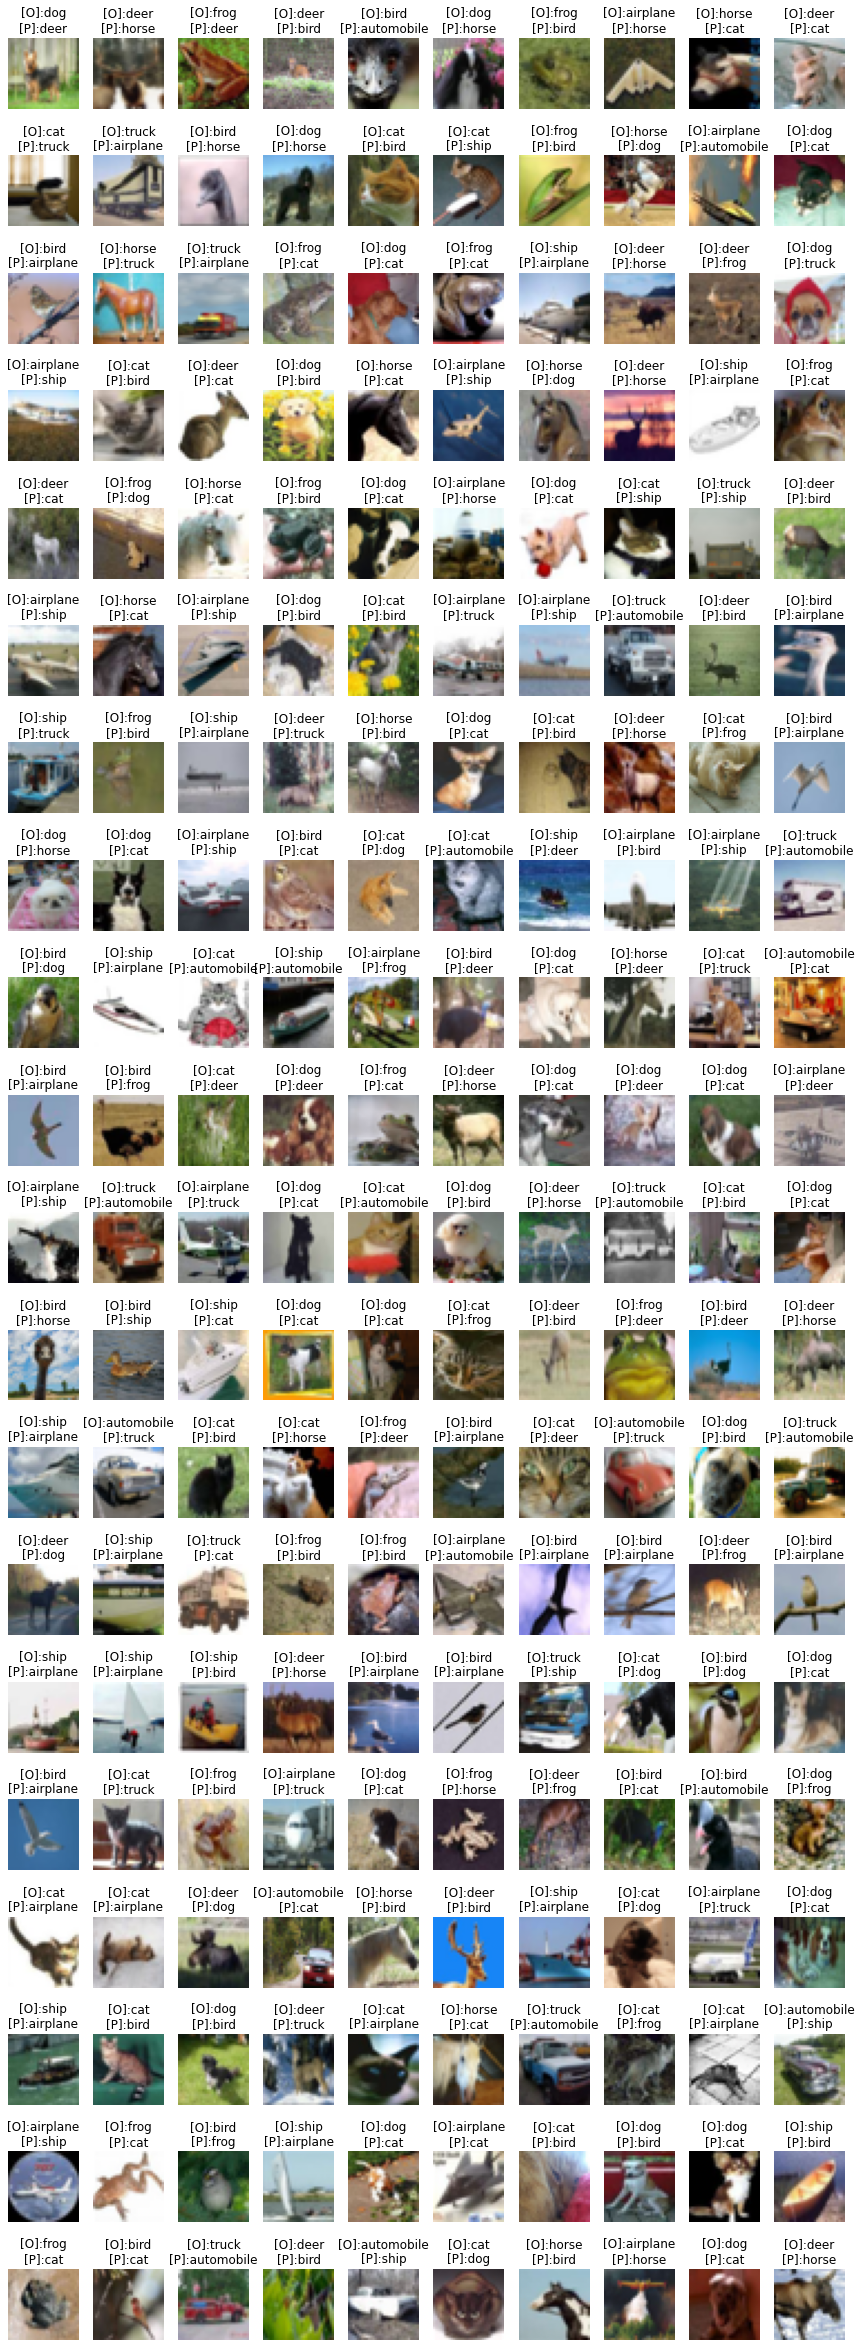

In [76]:
import numpy as np
# 找出True(預測錯誤)的位置
idx = np.nonzero(pre != y_test_1d)[0]
idx = idx[:200]
pre_false_label = y_test_1d[idx]
pre_false_pre = pre[idx]
pre_false_img = x_test[idx]

plt.figure(figsize=(15, 45))
width = 10
height = len(idx) // width + 1
for i in range(len(idx)):
    plt.subplot(height, width, i+1)
    t = "[O]:{}\n[P]:{}".format(trans[pre_false_label[i]], trans[pre_false_pre[i]])
    plt.title(t)
    plt.axis("off")
    plt.imshow(pre_false_img[i])

url:https://autos.yahoo.com.tw/p/r/w880/car-trim/July2019/8632420af7f6d09706a4e8a81506cf47.jpeg
airplane 的機率: 0.0
automobile 的機率: 1.0
bird 的機率: 0.0
cat 的機率: 0.0
deer 的機率: 0.0
dog 的機率: 0.0
frog 的機率: 0.0
horse 的機率: 0.0
ship 的機率: 0.0
truck 的機率: 0.0


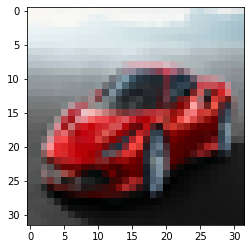

In [79]:
import requests
# pillow
from PIL import Image
url = input("url:")
response = requests.get(url, stream=True)
img = Image.open(response.raw).convert("RGB").resize((32, 32))
img_np = np.array(img) / 255
# (32, 32, 3) -> (1, 32, 32, 3)
img_np = img_np.reshape(1, 32, 32, 3)
proba = model.predict(img_np)[0]
for p, n in zip(proba, trans):
    print(n, "的機率:", round(p, 3))
plt.imshow(img)